In [1]:
import json
from collections import Counter

# File path to the COCO annotation file
annotation_file = r"C:/Users/natha/OneDrive/Desktop/Applied Machine Learning/Run-Through_Switch/annotations/instances_default.json"

# Labels to count
target_labels = {"open_switch", "closed_switch", "straight"}

# Load the COCO annotation file
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Get category mappings
categories = {category['id']: category['name'] for category in coco_data['categories']}

# Initialize a counter for the target labels
label_counter = Counter()

# Iterate over the annotations to count the labels
for annotation in coco_data['annotations']:
    category_id = annotation['category_id']
    category_name = categories.get(category_id, None)
    if category_name in target_labels:
        label_counter[category_name] += 1

# Display the counts
for label in target_labels:
    print(f"{label}: {label_counter[label]}")


closed_switch: 143
straight: 498
open_switch: 175


In [3]:
# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available.")
else:
    print("GPU is not available.")


GPU is not available.


In [1]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import shutil

# Paths
annotation_file = r"C:/Users/natha/OneDrive/Desktop/Applied Machine Learning/Run-Through_Switch/annotations/instances_default.json"
image_dir = r"C:/Users/natha/OneDrive/Desktop/Applied Machine Learning/Run-Through_Switch/images"
output_dir = r"C:/Users/natha/OneDrive/Desktop/Applied Machine Learning/Run-Through_Switch/processed_data"

# Load COCO annotations
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Get category mapping
categories = {category['id']: category['name'] for category in coco_data['categories']}

# Filter annotations for closed_switch
annotations = coco_data['annotations']
closed_switch_images = {
    annotation['image_id']
    for annotation in annotations
    if categories[annotation['category_id']] == 'closed_switch'
}

# Prepare dataset directory structure
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for split in ['train', 'val', 'test']:
    for label in ['closed_switch', 'not_closed_switch']:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Split data into train, val, test
image_filenames = {img['id']: img['file_name'] for img in coco_data['images']}
image_ids = list(image_filenames.keys())
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 20% val of 80% train

# Helper function to copy images
def copy_images(image_ids, split):
    for image_id in image_ids:
        label = 'closed_switch' if image_id in closed_switch_images else 'not_closed_switch'
        src = os.path.join(image_dir, image_filenames[image_id])
        dst = os.path.join(output_dir, split, label, image_filenames[image_id])
        if os.path.exists(src):
            shutil.copy(src, dst)

copy_images(train_ids, 'train')
copy_images(val_ids, 'val')
copy_images(test_ids, 'test')

# Data augmentation and data loaders
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 168 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


c:\Users\natha\OneDrive\Desktop\Applied Machine Learning\Run-Through_Switch\virtual_run-through_switch\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\natha\OneDrive\Desktop\Applied Machine Learning\Run-Through_Switch\virtual_run-through_switch\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8111 - loss: 0.9287 - val_accuracy: 0.8235 - val_loss: 0.5161
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 863ms/step - accuracy: 0.8376 - loss: 0.5188 - val_accuracy: 0.8235 - val_loss: 0.5111
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 757ms/step - accuracy: 0.8239 - loss: 0.5005 - val_accuracy: 0.8235 - val_loss: 0.4842
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 748ms/step - accuracy: 0.8140 - loss: 0.4831 - val_accuracy: 0.8235 - val_loss: 0.4801
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 845ms/step - accuracy: 0.8028 - loss: 0.4822 - val_accuracy: 0.8235 - val_loss: 0.4822
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step - accuracy: 0.8189 - loss: 0.4261 - val_accuracy: 0.8235 - val_loss: 0.5303
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 853ms/step - accuracy: 0.8285 - loss: 0.4487 - val_accuracy: 0.8235 - val_loss: 0.5121
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 747ms/step - accuracy: 0.8150 - loss: 0.3825 - val_accuracy: 0.8235 - val_loss: 0.

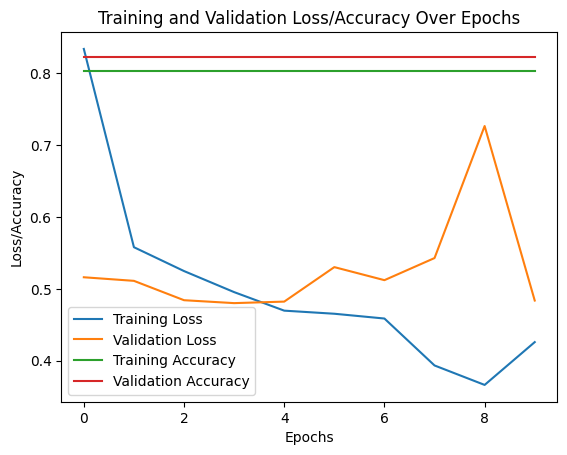

In [3]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# Training loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.title('Training and Validation Loss/Accuracy Over Epochs')
plt.show()


In [5]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import shutil
from tensorflow.keras.callbacks import EarlyStopping  # Import the EarlyStopping callback

# Paths
annotation_file = r"C:/Users/natha/OneDrive/Desktop/Applied Machine Learning/Run-Through_Switch/annotations/instances_default.json"
image_dir = r"C:/Users/natha/OneDrive/Desktop/Applied Machine Learning/Run-Through_Switch/images"
output_dir = r"C:/Users/natha/OneDrive/Desktop/Applied Machine Learning/Run-Through_Switch/processed_data"

# Load COCO annotations
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Get category mapping
categories = {category['id']: category['name'] for category in coco_data['categories']}

# Filter annotations for closed_switch
annotations = coco_data['annotations']
closed_switch_images = {
    annotation['image_id']
    for annotation in annotations
    if categories[annotation['category_id']] == 'closed_switch'
}

# Prepare dataset directory structure
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for split in ['train', 'val', 'test']:
    for label in ['closed_switch', 'not_closed_switch']:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Split data into train, val, test
image_filenames = {img['id']: img['file_name'] for img in coco_data['images']}
image_ids = list(image_filenames.keys())
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 20% val of 80% train

# Helper function to copy images
def copy_images(image_ids, split):
    for image_id in image_ids:
        label = 'closed_switch' if image_id in closed_switch_images else 'not_closed_switch'
        src = os.path.join(image_dir, image_filenames[image_id])
        dst = os.path.join(output_dir, split, label, image_filenames[image_id])
        if os.path.exists(src):
            shutil.copy(src, dst)

copy_images(train_ids, 'train')
copy_images(val_ids, 'val')
copy_images(test_ids, 'test')

# Data augmentation and data loaders
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping callback (added here)
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Stop after 3 epochs without improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model with early stopping (added here)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]  # Add early stopping callback here
)

# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 168 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


c:\Users\natha\OneDrive\Desktop\Applied Machine Learning\Run-Through_Switch\virtual_run-through_switch\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\natha\OneDrive\Desktop\Applied Machine Learning\Run-Through_Switch\virtual_run-through_switch\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6381 - loss: 0.7630 - val_accuracy: 0.8235 - val_loss: 0.4962
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7771 - loss: 0.5785 - val_accuracy: 0.8235 - val_loss: 0.5238
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7816 - loss: 0.5264 - val_accuracy: 0.8235 - val_loss: 0.4804
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7992 - loss: 0.4902 - val_accuracy: 0.8235 - val_loss: 0.4786
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8184 - loss: 0.4449 - val_accuracy: 0.8235 - val_loss: 0.5110
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 783ms/step - accuracy: 0.8359 - loss: 0.4298 - val_accuracy: 0.8088 - val_loss: 0.5298
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step - accuracy: 0.8347 - loss: 0.4194 - val_accuracy: 0.8235 - val_loss: 0.5466
Found 53 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.6967 - loss: 0.6825
Test Accuracy: 0.72

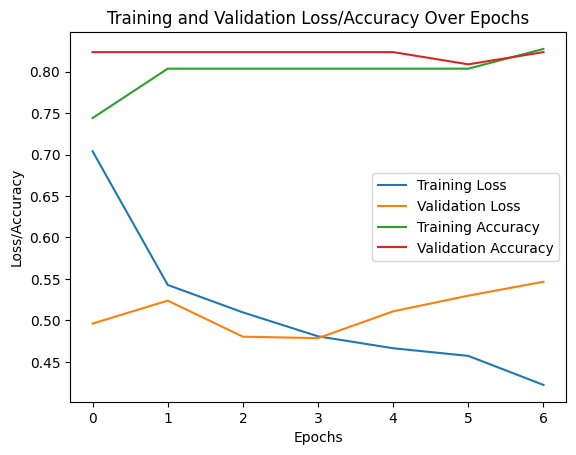

In [6]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# Training loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.title('Training and Validation Loss/Accuracy Over Epochs')
plt.show()